In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from scipy import optimize
from IPython import display
import json

In [2]:
def read_parameters(filename):
    with open(filename) as f:
        return json.loads(f.read())

In [20]:
#Load without import (So I won't need to restart the kernel all the time)
with open("molecule.py") as f: exec(f.read())
with open("simulation.py") as f: exec(f.read())
with open("multispecies_simulation.py") as f: exec(f.read())

In [21]:
fast = Simulation(read_parameters("./setups/presentation/parameters_fast_diffusion.json"))
fast.run()

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

In [126]:
mids = np.linspace(.1,.4,50)
slows = np.linspace(.2,.8,50)

mid_params = read_parameters("./setups/presentation/parameters_medium_diffusion.json")
slow_params = read_parameters("./setups/presentation/parameters_slow_diffusion.json")

mid_params[NUMBER_OF_MOLECULES_KEY] = 4000
slow_params[NUMBER_OF_MOLECULES_KEY] = 4000

two_species_simulations = []
args = [] 
args_from_MLE = []

for s,m in tqdm(list(zip(mids, slows))):
    
    mid_params[DIFFUSION_COEFFICIENT_KEY] = m
    slow_params[DIFFUSION_COEFFICIENT_KEY] = s
    
    mid = Simulation(mid_params)
    slow = Simulation(slow_params)
    
    
    mid.run(verbose=False)
    slow.run(verbose=False)
    
    tss = TwoSpeciesSimulation(mid, slow)
    two_species_simulations.append(tss)
    
    n = 4
    bounds = [[.05,.2,0],[ .6, 1,100]]
    
    _args, [X, Y, aY] = tss.approxiamte_diffusion_coefficients(p0 = [.2,.4, .5],journey_length=n+1,
                                                              bounds = bounds)
    args.append(_args)
    
    delta_t = tss.step_time_in_seconds;
    msds = tss.get_msds(n)
    
    def log_likelihoody(msd, D1, D2, A):
        return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                    A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

    def single_species_dist(msd, n, D, delta_t):
        return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                      np.exp(-msd/(2*(2*D*delta_t)))

    def lf(args):
        D1, D2, A = args
        return -log_likelihoody(msds,D1, D2, A)

    args_from_MLE.append(optimize.minimize(lf, x0 = _args, tol = 1e-14, bounds = np.transpose(bounds)).x)

args_from_MLE= np.array(args_from_MLE).T
args= np.array(args).T
    

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

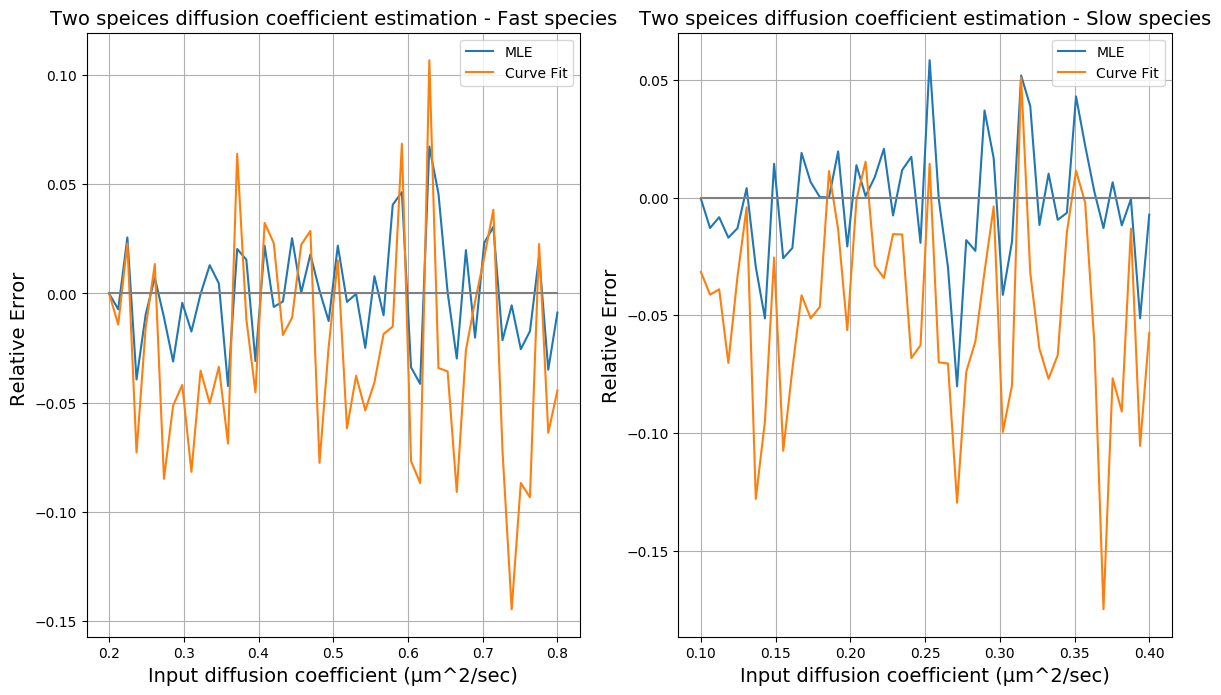

In [134]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)

relative_error_mle_slow =(args_from_MLE[1]-slows)/slows
relative_error_cf_slow = (args[1]-slows)/slows
plt.plot(slows, (relative_error_mle_slow))
plt.plot(slows, (relative_error_cf_slow))
plt.plot(slows, slows*0, 'grey')
plt.grid()
plt.title("Two speices diffusion coefficient estimation - Fast species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error ", fontsize = 14)
plt.legend(["MLE","Curve Fit"])

plt.subplot(1,2,2)
plt.grid()
relative_error_mle_mid = (args_from_MLE[0]-mids)/mids
relative_error_cf_mid = (args[0]-mids)/mids
plt.plot(mids, (relative_error_mle_mid))
plt.plot(mids, (relative_error_cf_mid))
plt.plot(mids, mids*0, 'grey')
plt.title("Two speices diffusion coefficient estimation - Slow species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error", fontsize = 14)
plt.legend(["MLE","Curve Fit"])


In [133]:
np.mean(np.abs(relative_error_cf_mid))

0.0529116525632028

In [132]:
np.mean(np.abs(relative_error_cf_slow))

0.04598325173156942

In [123]:
mids = np.linspace(.1,.4,50)
slows = np.linspace(.2,.8,50)

mid_params = read_parameters("./setups/presentation/parameters_medium_diffusion.json")
slow_params = read_parameters("./setups/presentation/parameters_slow_diffusion.json")

mid_params[NUMBER_OF_MOLECULES_KEY] = 1000
slow_params[NUMBER_OF_MOLECULES_KEY] = 1000

two_species_simulations = []
args = [] 
args_from_MLE = []

for s,m in tqdm(list(zip(mids, slows))):
    
    mid_params[DIFFUSION_COEFFICIENT_KEY] = m
    slow_params[DIFFUSION_COEFFICIENT_KEY] = s
    
    mid = Simulation(mid_params)
    slow = Simulation(slow_params)
    
    
    mid.run(verbose=False)
    slow.run(verbose=False)
    
    tss = TwoSpeciesSimulation(mid, slow)
    two_species_simulations.append(tss)
    
    n = 4
    bounds = [[.05,.2,0],[ .6, 1,100]]
    
    _args, [X, Y, aY] = tss.approxiamte_diffusion_coefficients(p0 = [.2,.4, .5],journey_length=n+1,
                                                              bounds = bounds)
    args.append(_args)
    
    delta_t = tss.step_time_in_seconds;
    msds = tss.get_msds(n)
    
    def log_likelihoody(msd, D1, D2, A):
        return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                    A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

    def single_species_dist(msd, n, D, delta_t):
        return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                      np.exp(-msd/(2*(2*D*delta_t)))

    def lf(args):
        D1, D2, A = args
        return -log_likelihoody(msds,D1, D2, A)

    args_from_MLE.append(optimize.minimize(lf, x0 = _args, tol = 1e-14, bounds = np.transpose(bounds)).x)

args_from_MLE= np.array(args_from_MLE).T
args= np.array(args).T
    

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

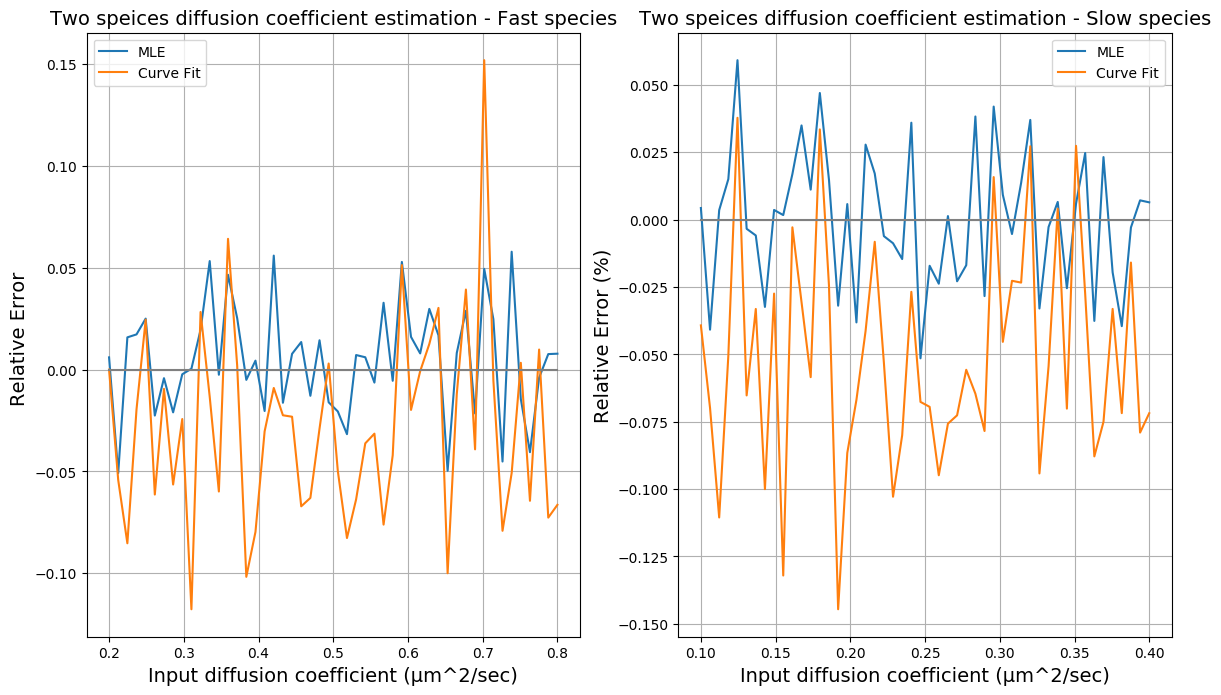

In [111]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)

relative_error_mle_slow =(args_from_MLE[1]-slows)/slows
relative_error_cf_slow = (args[1]-slows)/slows
plt.plot(slows, (relative_error_mle_slow))
plt.plot(slows, (relative_error_cf_slow))
plt.plot(slows, slows*0, 'grey')
plt.grid()
plt.title("Two speices diffusion coefficient estimation - Fast species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error ", fontsize = 14)
plt.legend(["MLE","Curve Fit"])

plt.subplot(1,2,2)
plt.grid()
relative_error_mle_mid = (args_from_MLE[0]-mids)/mids
relative_error_cf_mid = (args[0]-mids)/mids
plt.plot(mids, (relative_error_mle_mid))
plt.plot(mids, (relative_error_cf_mid))
plt.plot(mids, mids*0, 'grey')
plt.title("Two speices diffusion coefficient estimation - Slow species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error", fontsize = 14)
plt.legend(["MLE","Curve Fit"])


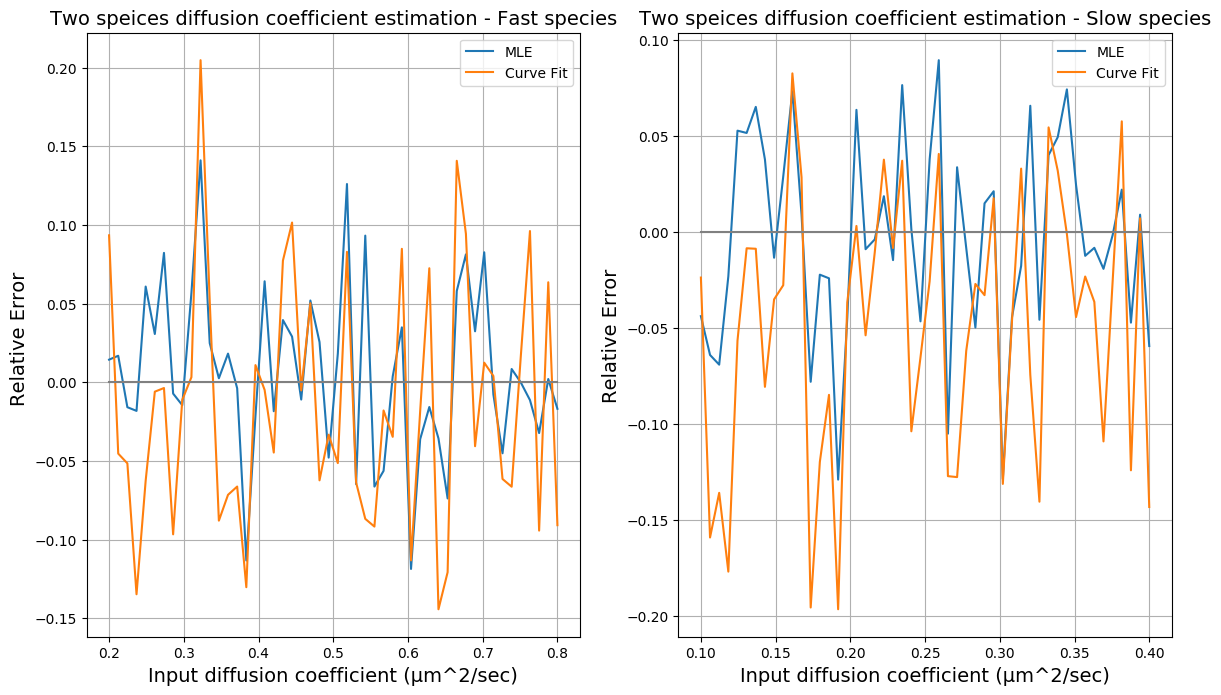

In [125]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)

relative_error_mle_slow =(args_from_MLE[1]-slows)/slows
relative_error_cf_slow = (args[1]-slows)/slows
plt.plot(slows, (relative_error_mle_slow))
plt.plot(slows, (relative_error_cf_slow))
plt.plot(slows, slows*0, 'grey')
plt.grid()
plt.title("Two speices diffusion coefficient estimation - Fast species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error ", fontsize = 14)
plt.legend(["MLE","Curve Fit"])

plt.subplot(1,2,2)
plt.grid()
relative_error_mle_mid = (args_from_MLE[0]-mids)/mids
relative_error_cf_mid = (args[0]-mids)/mids
plt.plot(mids, (relative_error_mle_mid))
plt.plot(mids, (relative_error_cf_mid))
plt.plot(mids, mids*0, 'grey')
plt.title("Two speices diffusion coefficient estimation - Slow species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error", fontsize = 14)
plt.legend(["MLE","Curve Fit"])


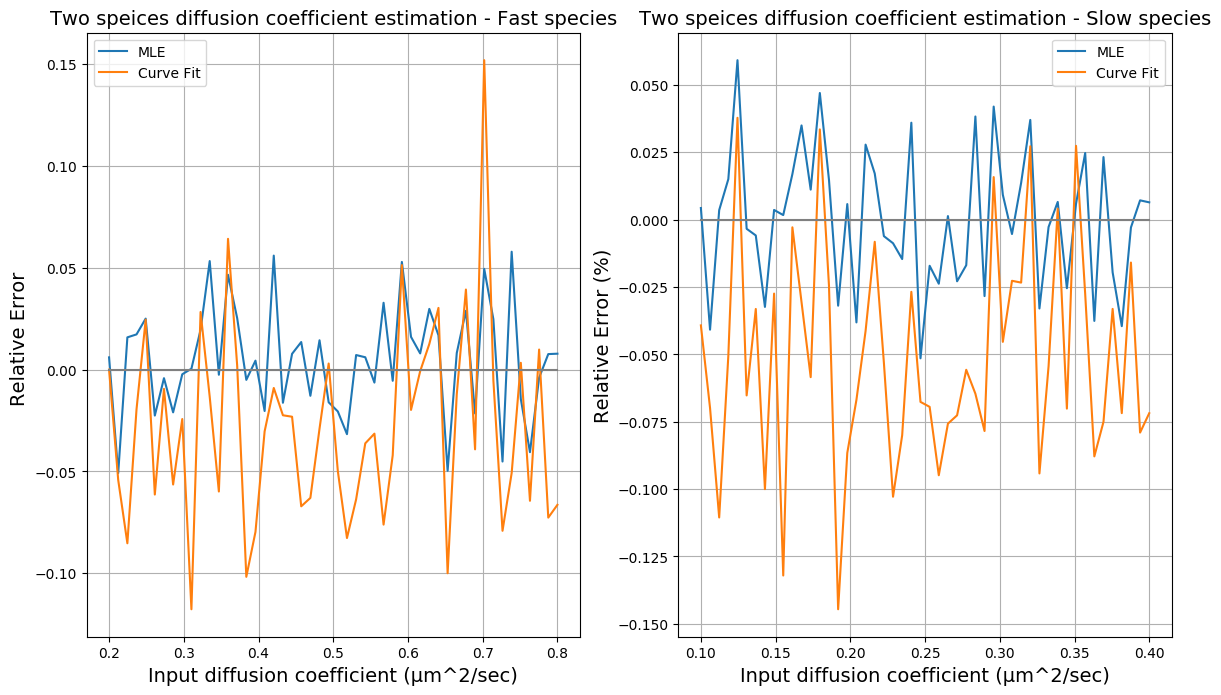

In [111]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)

relative_error_mle_slow =(args_from_MLE[1]-slows)/slows
relative_error_cf_slow = (args[1]-slows)/slows
plt.plot(slows, (relative_error_mle_slow))
plt.plot(slows, (relative_error_cf_slow))
plt.plot(slows, slows*0, 'grey')
plt.grid()
plt.title("Two speices diffusion coefficient estimation - Fast species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error ", fontsize = 14)
plt.legend(["MLE","Curve Fit"])

plt.subplot(1,2,2)
plt.grid()
relative_error_mle_mid = (args_from_MLE[0]-mids)/mids
relative_error_cf_mid = (args[0]-mids)/mids
plt.plot(mids, (relative_error_mle_mid))
plt.plot(mids, (relative_error_cf_mid))
plt.plot(mids, mids*0, 'grey')
plt.title("Two speices diffusion coefficient estimation - Slow species", fontsize = 14)
plt.xlabel("Input diffusion coefficient (µm^2/sec)", fontsize = 14)
plt.ylabel("Relative Error (%)", fontsize = 14)
plt.legend(["MLE","Curve Fit"])


In [118]:
np.mean((relative_error_mle_mid))

0.0001413556318546924

In [119]:
np.mean((relative_error_cf_mid))

-0.05118758711278424

In [120]:
np.mean((relative_error_cf_slow))

-0.027976495240033396

In [122]:
np.mean((relative_error_mle_slow))

0.004943765259345786

In [298]:
mids = np.linspace(.1,.4)
slows = np.linspace(.01,.04)

mid_params = read_parameters("./setups/presentation/parameters_medium_diffusion.json")
slow_params = read_parameters("./setups/presentation/parameters_slow_diffusion.json")

two_species_simulations = []
args = [] 
args_from_MLE = []

for s,m in tqdm(list(zip(mids, slows))):
    
    mid_params[DIFFUSION_COEFFICIENT_KEY] = m
    slow_params[DIFFUSION_COEFFICIENT_KEY] = s
    mid_params[NUMBER_OF_MOLECULES_KEY] = 150
    slow_params[NUMBER_OF_MOLECULES_KEY] = 150
    
    mid = Simulation(mid_params)
    slow = Simulation(slow_params)
    
    
    mid.run(verbose=False)
    slow.run(verbose=False)
    
    tss = TwoSpeciesSimulation(mid, slow)
    two_species_simulations.append(tss)
    
    n = 4
    
    _args, [X, Y, aY] = tss.approxiamte_diffusion_coefficients(p0 = [.2,.02, .5],journey_length=n+1)
    args.append(_args)
    
    delta_t = tss.step_time_in_seconds;
    msds = tss.get_msds(n)
    
    def log_likelihoody(msd, D1, D2, A):
        return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                    A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

    def single_species_dist(msd, n, D, delta_t):
        return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                      np.exp(-msd/(2*(2*D*delta_t)))

    def lf(args):
        D1, D2, A = args
        return -log_likelihoody(msds,D1, D2, A)

    args_from_MLE.append(optimize.minimize(lf, x0 = _args, tol = 1e-14).x)

args_from_MLE= np.array(args_from_MLE).T
args= np.array(args).T
    

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: overflow encountered in multiply


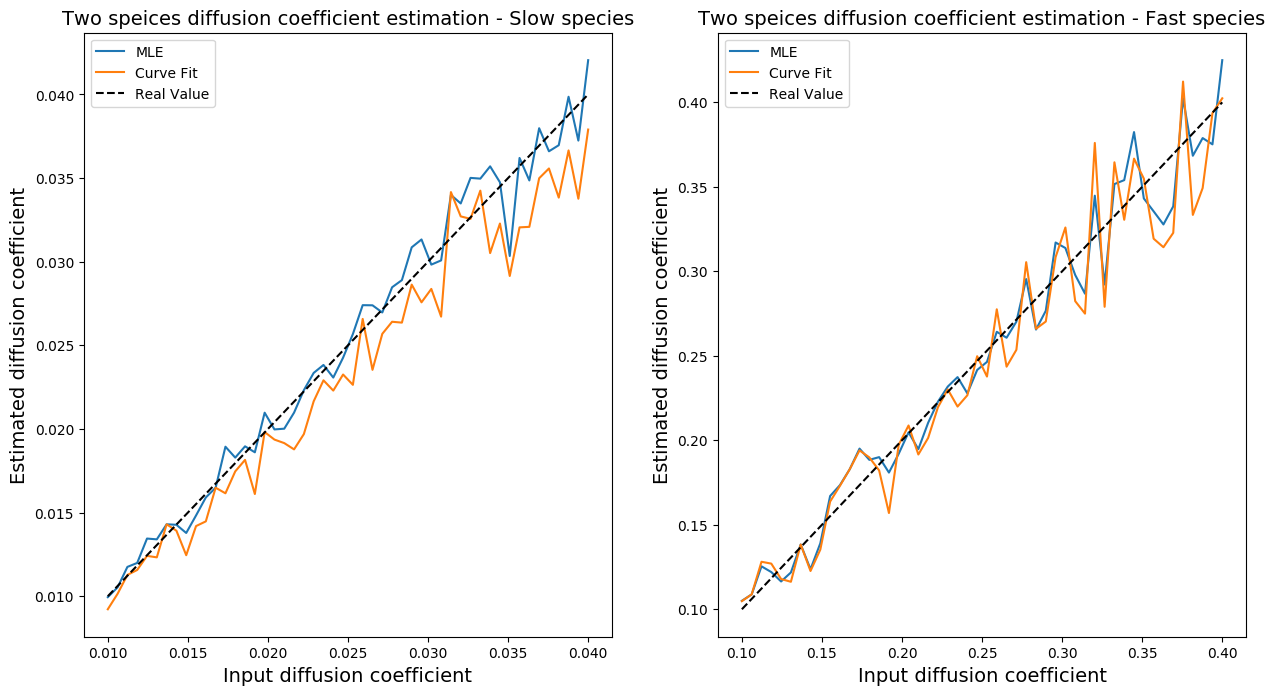

In [299]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(slows, args_from_MLE[1])
plt.plot(slows, args[1])
plt.plot(slows, slows, 'k--')
plt.title("Two speices diffusion coefficient estimation - Slow species", fontsize = 14)
plt.xlabel("Input diffusion coefficient", fontsize = 14)
plt.ylabel("Estimated diffusion coefficient", fontsize = 14)
plt.legend(["MLE","Curve Fit","Real Value"])

plt.subplot(1,2,2)
plt.plot(mids, args_from_MLE[0])
plt.plot(mids, args[0])
plt.plot(mids, mids, 'k--')
plt.title("Two speices diffusion coefficient estimation - Fast species", fontsize = 14)
plt.xlabel("Input diffusion coefficient", fontsize = 14)
plt.ylabel("Estimated diffusion coefficient", fontsize = 14)
plt.legend(["MLE","Curve Fit","Real Value"])


In [276]:
mids = np.linspace(.01,.04)
slows = np.linspace(.001,.004)

mid_params = read_parameters("./setups/presentation/parameters_medium_diffusion.json")
slow_params = read_parameters("./setups/presentation/parameters_slow_diffusion.json")

two_species_simulations = []
args = [] 
args_from_MLE = []

for s,m in tqdm(list(zip(mids, slows))):
    
    mid_params[DIFFUSION_COEFFICIENT_KEY] = m
    slow_params[DIFFUSION_COEFFICIENT_KEY] = s
    
    mid = Simulation(mid_params)
    slow = Simulation(slow_params)
    
    
    mid.run(verbose=False)
    slow.run(verbose=False)
    
    tss = TwoSpeciesSimulation(mid, slow)
    two_species_simulations.append(tss)
    
    n = 4
    
    _args, [X, Y, aY] = tss.approxiamte_diffusion_coefficients(p0 = [.01,.1, .5],journey_length=n+1)
    args.append(_args)
    
    delta_t = tss.step_time_in_seconds;
    msds = tss.get_msds(n)
    
    def log_likelihoody(msd, D1, D2, A):
        return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                    A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

    def single_species_dist(msd, n, D, delta_t):
        return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                      np.exp(-msd/(2*(2*D*delta_t)))

    def lf(args):
        D1, D2, A = args
        return -log_likelihoody(msds,D1, D2, A)

    args_from_MLE.append(optimize.minimize(lf, x0 = _args, tol = 1e-14).x)

args_from_MLE= np.array(args_from_MLE).T
args= np.array(args).T
    

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWa

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:64: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in exp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: overflow encountered in multiply
/Library/Frameworks/Python.fram

In [288]:
f = args_from_MLE[0] < .04

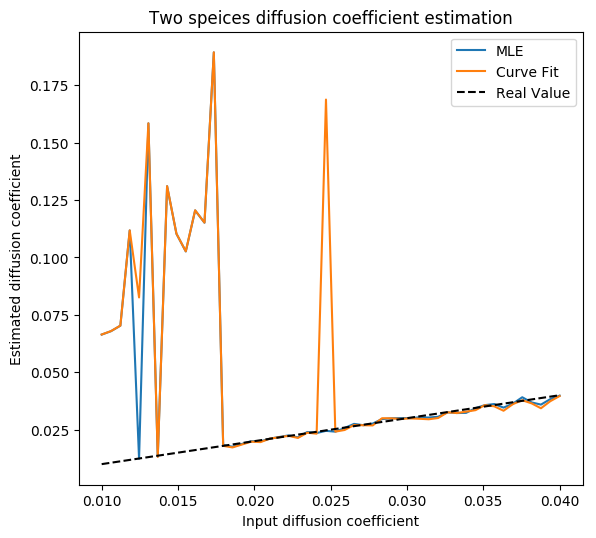

In [292]:
plt.plot(mids[f], args_from_MLE[1][f])
plt.plot(mids[f], args[1][f])
plt.plot(mids, mids, 'k--')
plt.title("Two speices diffusion coefficient estimation")
plt.xlabel("Input diffusion coefficient")
plt.ylabel("Estimated diffusion coefficient")
plt.legend(["MLE","Curve Fit","Real Value"])

[0.26596097 0.02314066 1.00709003]


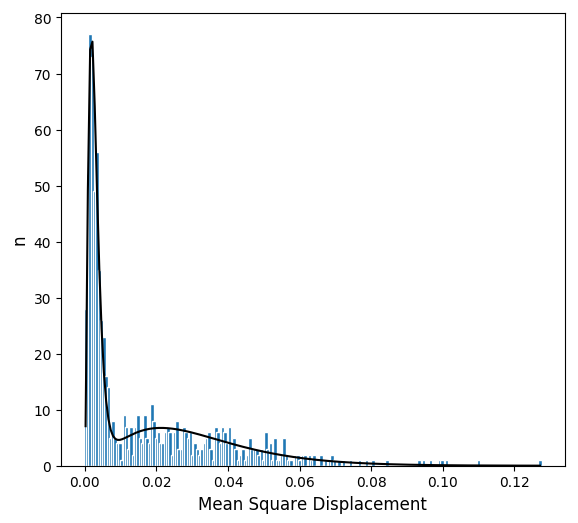

In [122]:
multiple_species1 = TwoSpeciesSimulation(slow, med)
args, [X, Y, aY] = multiple_species1.approxiamte_diffusion_coefficients(p0 = [.2,.02, .5])
plt.bar(X,Y, .001, edgecolor='white')
plt.plot(X,aY, 'k')
plt.xlabel("Mean Square Displacement", fontsize = 12);plt.ylabel("n", fontsize = 12)
print(args)

In [219]:
n = 4
delta_t = multiple_species1.subsimulations[0].step_time_in_seconds;
msds = multiple_species1.get_msds(n)
def log_likelihoody(msd, D1, D2, A):
    return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

def single_species_dist(msd, n, D, delta_t):
    return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                  np.exp(-msd/(2*(2*D*delta_t)))
    
def lf(args):
    D1, D2, A = args
    return -log_likelihoody(msds,D1, D2, A)

optimize.minimize(lf, x0 = [.1,.01,1], tol = 1e-14)

      fun: -2468.6944989806975
 hess_inv: array([[4.36791639e-05, 9.08491170e-07, 6.39523251e-05],
       [9.08491170e-07, 5.02733297e-07, 4.35076530e-06],
       [6.39523251e-05, 4.35076530e-06, 4.92115541e-03]])
      jac: array([0.00000000e+00, 3.05175781e-05, 0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 146
      nit: 19
     njev: 29
   status: 2
  success: False
        x: array([0.27596192, 0.02686106, 1.30892787])

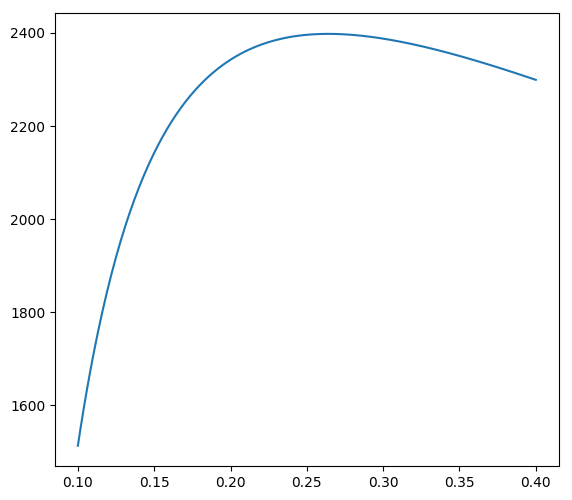

In [192]:
X = np.linspace(.1,.4,300)
Y = [log_likelihoody(msds, x, .02, 1) for x in X]
plt.plot(X, Y)

[2.58451163 0.23769383 3.64337121]


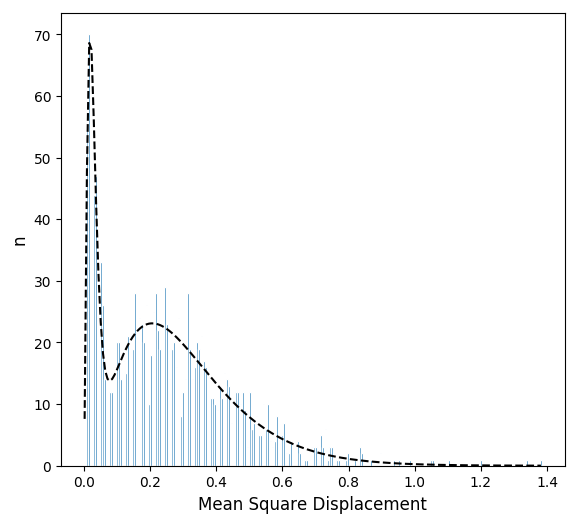

In [193]:
multiple_species2 = TwoSpeciesSimulation(fast, med)
args, [X, Y, aY] = multiple_species2.approxiamte_diffusion_coefficients(p0 = [2,.2, .5])
plt.bar(X,Y, .005, edgecolor='white')
plt.xlabel("Mean Square Displacement", fontsize = 12);plt.ylabel("n", fontsize = 12)
plt.plot(X,aY, '--k')
print(args)

In [216]:
n = 5
delta_t = multiple_species2.subsimulations[0].step_time_in_seconds;
msds = multiple_species2.get_msds(n)
def log_likelihoody(msd, D1, D2, A):
    return np.sum(np.log((single_species_dist(msd, n, D1,delta_t) +
                                A*single_species_dist(msd, n, D2,delta_t))/(A+1)))

def single_species_dist(msd, n, D, delta_t):
    return (1/(2*D*delta_t))**n * (1/(np.math.factorial(n-1)*2**n)) * msd**(n-1) * \
                  np.exp(-msd/(2*(2*D*delta_t)))
    
def lf(args):
    D1, D2, A = args
    return -log_likelihoody(msds,D1, D2, A)

optimize.minimize(lf, x0 = [.23,2.3,1], tol = 1e-13)

      fun: -233.92647705151978
 hess_inv: array([[5.12026108e-05, 7.20071347e-06, 9.17478791e-05],
       [7.20071347e-06, 2.46338836e-03, 7.99325429e-05],
       [9.17478791e-05, 7.99325429e-05, 6.87118278e-04]])
      jac: array([3.05175781e-05, 3.81469727e-06, 1.90734863e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 944
      nit: 17
     njev: 186
   status: 2
  success: False
        x: array([0.27526341, 2.66491736, 1.69009454])